# CS:GO match prediction
### Patrik Veselý

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import jsonlines
import re
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [24]:
matches = pd.read_csv("matches.csv")
matches = matches.drop(columns="Unnamed: 0")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## CS:GO
* 2 teams - Terrorists vs Counter-terrorists
* 5 players each team
* Max 30 rounds each map

## Dataset
* htlv.org
* 5049 records

In [18]:
matches.describe(include = 'object').transpose()

,count,unique,top,freq
team1_name,5049,495,SKADE,82
team2_name,5049,603,forZe,70
best_of,5049,13,Best of 3,2627
match_type,5049,480,* Quarter-final,437
date,5049,399,2021-04-15,39
prize,5049,331,"$50,000",580
teams,5044,25,16,1438
location,5044,51,Europe (Online),3129
map1,5049,10,Inferno,909
map2,4443,11,Inferno,787


In [21]:
matches.filter(regex=("team1_player1_.*")).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
team1_player1_rating,5049.0,1.024054,0.075912,0.380,0.980,1.02,1.070,1.340
team1_player1_DPR,5049.0,0.670093,0.034409,0.580,0.650,0.67,0.690,0.970
team1_player1_KAST,5049.0,0.698236,0.021817,0.424,0.689,0.70,0.712,0.756
team1_player1_impact,5049.0,1.048194,0.113044,0.170,0.980,1.05,1.110,1.470
team1_player1_ADR,5049.0,74.905962,4.625037,29.300,72.600,74.70,77.600,89.200
team1_player1_KPR,5049.0,0.684268,0.050615,0.260,0.660,0.69,0.710,0.850


Rating - special rating where 1.0 should be average
DPR - deaths per round
KAST - Percentage of rounds in which the player either had a kill, assist, survived or was traded
Impact - Measures impact made from multikills, opening kills, and clutches
ADR - averafe demage per round
KPR - kills per round

In [20]:
matches

,team1_name,team2_name,best_of,match_type,date,timestamp,prize,teams,location,map1,map2,map3,map4,map5,team1_player1_name,team1_player1_rating,team1_player1_DPR,team1_player1_KAST,team1_player1_impact,team1_player1_ADR,team1_player1_KPR,team1_player2_name,team1_player2_rating,team1_player2_DPR,team1_player2_KAST,team1_player2_impact,team1_player2_ADR,team1_player2_KPR,team1_player3_name,team1_player3_rating,team1_player3_DPR,team1_player3_KAST,team1_player3_impact,team1_player3_ADR,team1_player3_KPR,team1_player4_name,team1_player4_rating,team1_player4_DPR,team1_player4_KAST,team1_player4_impact,team1_player4_ADR,team1_player4_KPR,team1_player5_name,team1_player5_rating,team1_player5_DPR,team1_player5_KAST,team1_player5_impact,team1_player5_ADR,team1_player5_KPR,team2_player1_name,team2_player1_rating,team2_player1_DPR,team2_player1_KAST,team2_player1_impact,team2_player1_ADR,team2_player1_KPR,team2_player2_name,team2_player2_rating,team2_player2_DPR,team2_player2_KAST,team2_player2_impact,team2_player2_ADR,team2_player2_KPR,team2_player3_name,team2_player3_rating,team2_player3_DPR,team2_player3_KAST,team2_player3_impact,team2_player3_ADR,team2_player3_KPR,team2_player4_name,team2_player4_rating,team2_player4_DPR,team2_player4_KAST,team2_player4_impact,team2_player4_ADR,team2_player4_KPR,team2_player5_name,team2_player5_rating,team2_player5_DPR,team2_player5_KAST,team2_player5_impact,team2_player5_ADR,team2_player5_KPR,team1_points,team2_points,team1_wins,team2_wins
0,OG,Fiend,Best of 3 (Online),* Semi-final,2021-06-02,1622628000000,"$68,000",20,Europe (Online),Mirage,Inferno,Overpass,NaN,NaN,valde,1.09,0.65,0.725,1.11,80.5,0.74,Aleksib,0.97,0.66,0.713,1.05,75.5,0.65,niko,1.03,0.66,0.714,1.05,75.6,0.70,mantuu,1.16,0.63,0.727,1.18,77.7,0.75,flameZ,1.14,0.67,0.715,1.18,80.8,0.74,bubble,1.01,0.65,0.716,1.04,75.1,0.68,v1c7oR,1.03,0.67,0.730,1.12,77.2,0.70,dream3r,1.12,0.62,0.737,1.08,77.9,0.75,REDSTAR,1.10,0.64,0.714,1.08,75.3,0.70,h4rn,1.11,0.61,0.715,1.08,72.6,0.71,2,0,True,False
1,Entropiq Prague,Sampi,Best of 3 (Online),* Semi-final,2021-05-28,1622225700000,"$9,630",4+,Europe (Online),Vertigo,Dust2,Overpass,NaN,NaN,AJTT,1.03,0.68,0.706,0.98,74.1,0.67,leckr,0.96,0.69,0.686,0.89,69.3,0.63,HONES,0.94,0.72,0.657,0.94,70.6,0.63,capseN,1.03,0.67,0.677,1.04,71.3,0.67,MoriiSko,0.98,0.73,0.677,1.00,72.7,0.64,queztone,1.02,0.69,0.700,1.07,77.5,0.71,Pechyn,1.05,0.68,0.708,1.02,76.1,0.69,kinzo,0.97,0.68,0.696,0.85,71.8,0.63,bery,1.01,0.68,0.698,0.99,72.7,0.65,noobiq,0.95,0.73,0.652,1.02,70.3,0.64,2,0,True,False
2,Lyngby Vikings,KOVA,Best of 3 (Online),* Swiss round 4 (teams with a 1-2 record). Los...,2021-05-28,1622225100000,8 Spots in Elisa Invitational Summer,16,Europe (Online),Nuke,Vertigo,Inferno,NaN,NaN,raalz,1.00,0.68,0.702,1.04,73.6,0.68,Daffu,1.05,0.67,0.710,1.00,74.4,0.67,birdfromsky,0.97,0.69,0.693,0.96,71.2,0.59,maNkz,1.00,0.69,0.696,0.99,71.9,0.63,J3nsyy,1.04,0.62,0.708,1.02,66.4,0.65,uli,1.00,0.67,0.704,1.01,76.3,0.68,pietola,0.92,0.67,0.687,0.90,69.5,0.62,Twixie,1.00,0.68,0.695,0.97,71.8,0.63,Spargo,1.05,0.68,0.677,1.13,71.3,0.70,Airax,0.90,0.72,0.655,0.90,67.9,0.58,2,1,True,False
3,G2,NIP,Best of 3 (Online),* Consolidation final,2021-05-28,1622228400000,"$50,000",16,Europe (Online),Mirage,Inferno,Dust2,NaN,NaN,JaCkz,1.01,0.68,0.706,1.09,75.8,0.69,NiKo,1.15,0.67,0.711,1.29,85.4,0.80,huNter-,1.13,0.67,0.723,1.25,85.6,0.78,AmaNEk,1.03,0.63,0.717,1.03,75.6,0.68,nexa,1.06,0.64,0.735,1.04,77.6,0.71,device,1.16,0.62,0.713,1.28,80.5,0.78,REZ,1.03,0.67,0.706,1.10,78.4,0.70,hampus,1.01,0.69,0.681,1.14,79.8,0.70,Plopski,1.10,0.66,0.718,1.10,78.4,0.71,ztr,0.94,0.69,0.665,0.88,68.0,0.62,1,2,False,True
4,Paquetá,Santos,Best of 3 (Online),* Lower bracket final,2021-05-28,1622235600000,"$1,650",6+,South America (Online),Nuke,Dust2,Overpass,NaN,NaN,DeStiNy,1.02,0.70,0.703,1.19,78.9,0.72,iDk,1.10,0.67,0.702,1.13,79.7,0.71,KHTEX,1.12,0.64,0.722,1.09,77.7,0.72,nython,1.13,0.67,0.710,1.17,76.9,0.75,dav1d,1.18,0.69,0.720,1.24,85.5,0.78,BobZ,0.93

## Data cleaning

There are too many distinct team name values -> drop team names

In [22]:
matches.filter(regex=("team[12]_name")).describe(include = 'object').transpose()

,count,unique,top,freq
team1_name,5049,495,SKADE,82
team2_name,5049,603,forZe,70


Same problem with match type -> drop

In [23]:
matches.filter(regex=("match_type")).describe(include = 'object').transpose()

,count,unique,top,freq
match_type,5049,480,* Quarter-final,437


Prize = money / qualification -> create 2 fields prize_money (numerical) and prize_qualification (binary)

Models should be independent of match date -> drop date

* train set first ~ 3/4 of original
* test set last ~ 1/4 of original

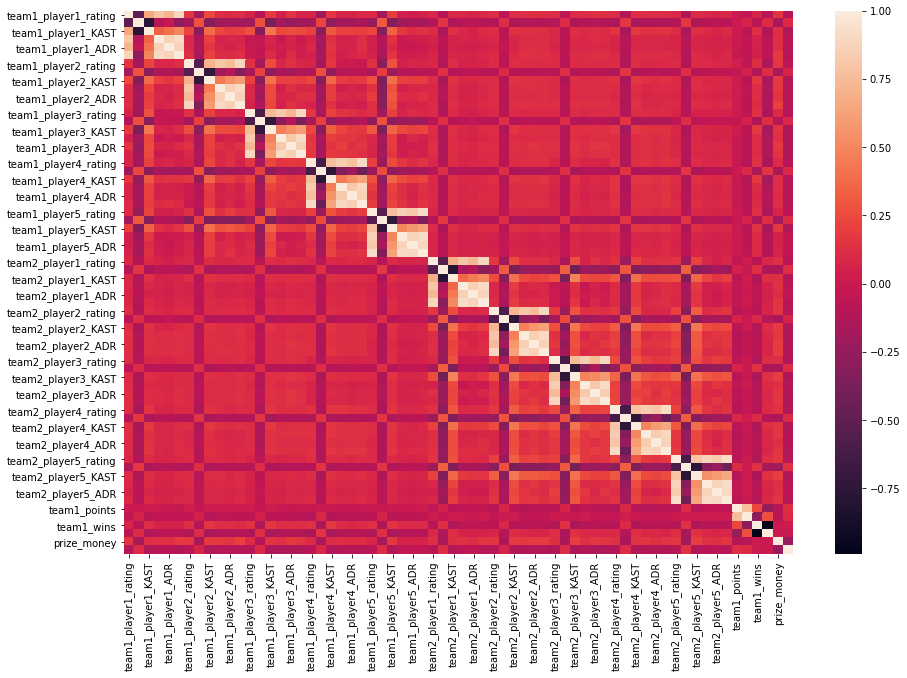

In [25]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr())
plt.show()

Categorical attributes:
* One-hot encoding

Numerical attributes:
* Original
* Normalized
* PCA 10 dimensions (explained variance = 99.98%)
* PCA 1 dimension (explained variance = 99.68%)


## Training

In [37]:
res_df = pd.read_csv("training_results.csv")
res_pivot = pd.pivot(res_df, values="test_acc", index='classifier', columns='data').sort_values('original', ascending=False)

Baseline solution = (# team 1 wins) / (# matches)

In [55]:
np.sum(train["team1_wins"].astype(int).to_numpy()) / train.shape[0]

0.5544109878499736

kNN classifier

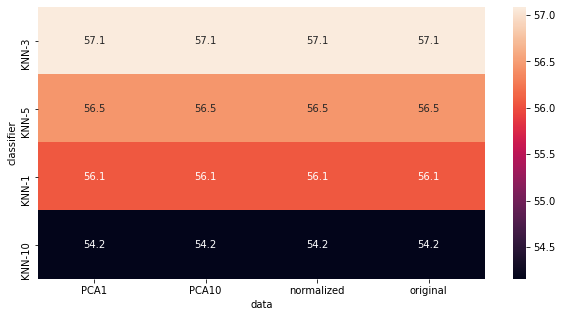

In [45]:
plt.figure(figsize=(10,5))
sns.heatmap(res_pivot.filter(like='KNN', axis=0), annot=True, fmt=".1f")
plt.show()

SVM

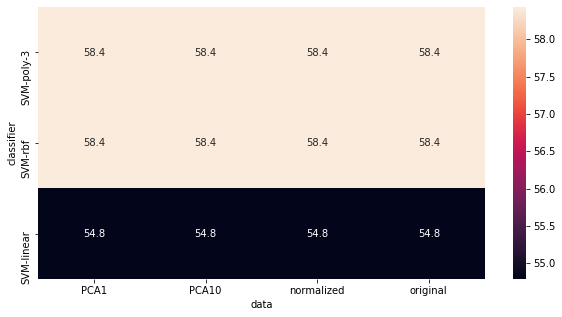

In [46]:
plt.figure(figsize=(10,5))
sns.heatmap(res_pivot.filter(like='SVM', axis=0), annot=True, fmt=".1f")
plt.show()

Perceptron and MLP

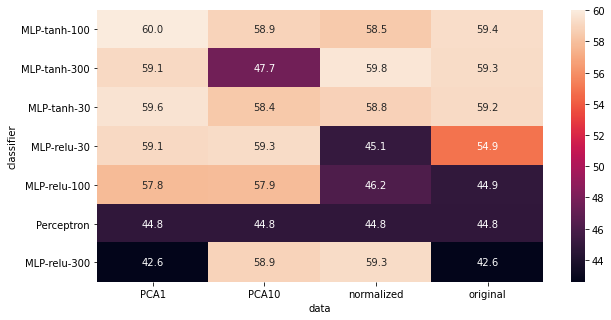

In [47]:
plt.figure(figsize=(10,5))
sns.heatmap(res_pivot.filter(regex='(Perceptron)|(MLP)', axis=0), annot=True, fmt=".1f")
plt.show()

Trees and forests

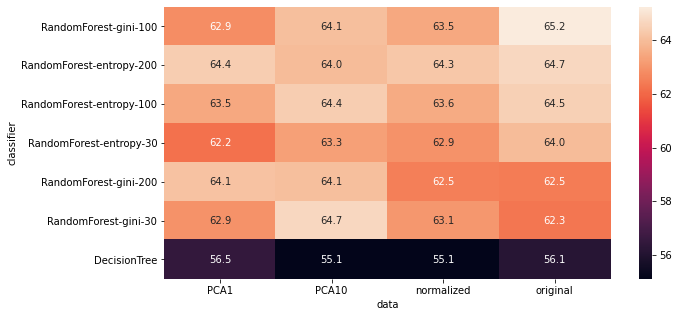

In [48]:
plt.figure(figsize=(10,5))
sns.heatmap(res_pivot.filter(regex='(DecisionTree)|(RandomForest.*)', axis=0), annot=True, fmt=".1f")
plt.show()

AdaBoost

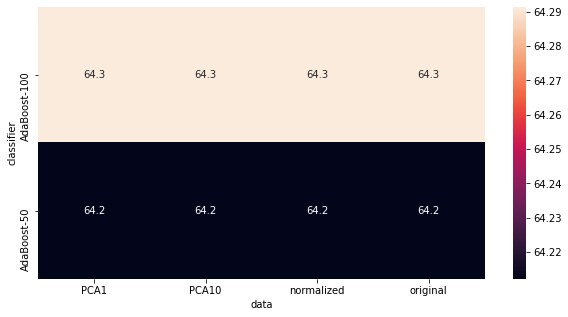

In [50]:
plt.figure(figsize=(10,5))
sns.heatmap(res_pivot.filter(regex='(Ada.*)', axis=0), annot=True, fmt=".1f")
plt.show()

Linear models

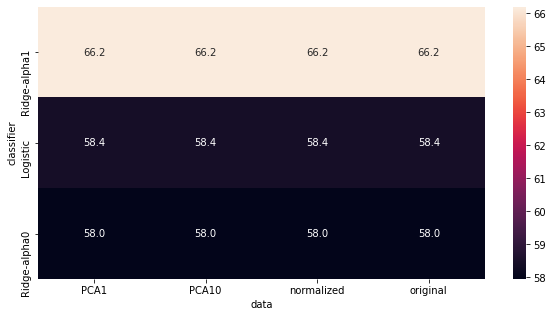

In [51]:
plt.figure(figsize=(10,5))
sns.heatmap(res_pivot.filter(regex='(Ridge.*)|(Logistic)', axis=0), annot=True, fmt=".1f")
plt.show()

Summary

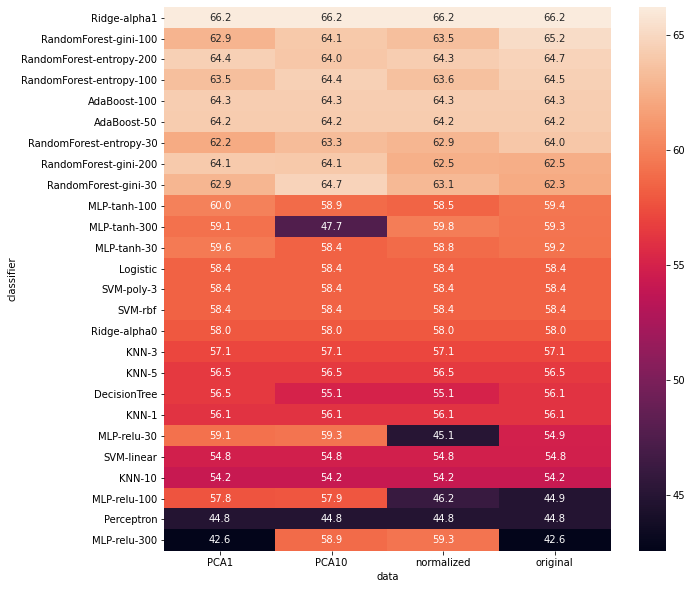

In [52]:
plt.figure(figsize=(10,10))
sns.heatmap(res_pivot, annot=True, fmt=".1f")
plt.show()

# Thank you for your attention
Git: https://github.com/Anophel/csgo-predictions